# Text Summarization

## Installing dependencies

In [ ]:
!pip install transformers
!pip install torch
!pip install rouge-score
!pip install datasets

In [ ]:
import nltk
import pandas as pd
import torch
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
from datasets import load_dataset
from rouge_score import rouge_scorer
from concurrent.futures import ThreadPoolExecutor

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Importing and Initalizaing Tranformer andd Pegasus models from Hugging Face

In [3]:
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-large")
model_base = PegasusForConditionalGeneration.from_pretrained("google/pegasus-large")
model_finetuned = PegasusForConditionalGeneration.from_pretrained("google/pegasus-arxiv")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-arxiv and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Moving the models to GPU if CUDA available

In [4]:
# Moving models to GPU if CUDA is available
if torch.cuda.is_available():
    model_base = model_base.to('cuda')
    model_finetuned = model_finetuned.to('cuda')

## Creating a Preprocessing Pipeline

In [5]:
def chunk_text(text, max_tokens, tokenizer):
    sentences = nltk.tokenize.sent_tokenize(text)
    current_chunk = []
    chunks = []
    current_len = 0

    for sentence in sentences:
        sentence_len = len(tokenizer.encode(sentence))
        if current_len + sentence_len > max_tokens:
            chunks.append(" ".join(current_chunk))
            current_chunk = []
            current_len = 0
        current_chunk.append(sentence)
        current_len += sentence_len

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

In [6]:
def prepare_batches(texts, max_tokens, batch_size):
    for text in texts:
        chunks = chunk_text(text, max_tokens, tokenizer)
        for i in range(0, len(chunks), batch_size):
            yield chunks[i:i + batch_size]

In [7]:
def summarize_batch(model, batch):
    batch_tokens = tokenizer(batch, truncation=True, padding=True, return_tensors="pt")
    if torch.cuda.is_available():
        batch_tokens = {key: val.to('cuda') for key, val in batch_tokens.items()}
    summary_ids = model.generate(**batch_tokens, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    return [tokenizer.decode(ids, skip_special_tokens=True) for ids in summary_ids]


In [8]:
def generate_summary(model, texts, max_tokens=512, batch_size=4):
    all_summaries = []
    with ThreadPoolExecutor() as executor:
        for text in texts:
            futures = []
            chunks = chunk_text(text, max_tokens, tokenizer)
            for i in range(0, len(chunks), batch_size):
                batch = chunks[i:i + batch_size]
                futures.append(executor.submit(summarize_batch, model, batch))

            # combining the summaries of all chunks from the same document
            document_summary = " ".join([chunk for future in futures for chunk in future.result()])
            all_summaries.append(document_summary)
    return all_summaries

### Importing data

In [9]:
import pandas as pd

# Load the dataset into a pandas DataFrame
df = pd.read_csv(r'C:\Users\alias\Comp 6480 Natural Language Processing\Project\Project code\Project Data\data.csv')

# Sample rows from the DataFrame
sampled_papers = df.sample(n=10)

In [10]:
sampled_papers

,article,abstract
124,"in this paper , we propose a simple distribute...",the fairness of ieee 802.11 wireless networks...
1000,the construction of several new detectors of g...,gravitational wave detectors will need optima...
811,cervical carcinoma is the second most common c...,the mortality related to cervical cancer can ...
776,the marginalization paradox ( mp ) is an appar...,it has recently been shown that the marginali...
394,stochastic resonance is one of effects demonst...,the archetypal system demonstrating stochasti...
69,with the rapid growth in demand for higher dat...,"in this article , we propose an improved mult..."
340,the internet is by far the world s most crucia...,`` net neutrality '' often refers to the poli...
110,"in fluid mechanics , the non - slip boundary c...",the composite torsional ultrasonic oscillator...
260,we define a _ sociotechnical system _ as one i...,"following established tradition , software en..."
427,the detection of the heart disease is very imp...,we compare the capability of wavelet function...


## Making Model Inferences on sampled text data

In [11]:
# Summarize papers
text_to_summarize = [paper for paper in sampled_papers['article']]
base_summaries = generate_summary(model_base, text_to_summarize)
finetuned_summaries = generate_summary(model_finetuned, text_to_summarize)

Token indices sequence length is longer than the specified maximum sequence length for this model (2507 > 1024). Running this sequence through the model will result in indexing errors


## Evaluation using ROGUE metrics

In [12]:
# Evaluating summaries
from statistics import mean

# Initializing the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# Initializing lists to store scores
rouge1_precision_scores = []
rouge1_recall_scores = []
rouge1_fmeasure_scores = []
rougeL_precision_scores = []
rougeL_recall_scores = []
rougeL_fmeasure_scores = []

# Evaluating summaries and collecting scores
for i in range(len(base_summaries)):
    reference_summary = sampled_papers.iloc[i]['abstract']
    scores_base = scorer.score(reference_summary, base_summaries[i])
    scores_finetuned = scorer.score(reference_summary, finetuned_summaries[i])
    
    rouge1_precision_scores.append((scores_base['rouge1'].precision + scores_finetuned['rouge1'].precision) / 2)
    rouge1_recall_scores.append((scores_base['rouge1'].recall + scores_finetuned['rouge1'].recall) / 2)
    rouge1_fmeasure_scores.append((scores_base['rouge1'].fmeasure + scores_finetuned['rouge1'].fmeasure) / 2)

    rougeL_precision_scores.append((scores_base['rougeL'].precision + scores_finetuned['rougeL'].precision) / 2)
    rougeL_recall_scores.append((scores_base['rougeL'].recall + scores_finetuned['rougeL'].recall) / 2)
    rougeL_fmeasure_scores.append((scores_base['rougeL'].fmeasure + scores_finetuned['rougeL'].fmeasure) / 2)

# Calculating the mean for each score
mean_rouge1_precision = mean(rouge1_precision_scores)
mean_rouge1_recall = mean(rouge1_recall_scores)
mean_rouge1_fmeasure = mean(rouge1_fmeasure_scores)
mean_rougeL_precision = mean(rougeL_precision_scores)
mean_rougeL_recall = mean(rougeL_recall_scores)
mean_rougeL_fmeasure = mean(rougeL_fmeasure_scores)

# Printing the average scores
print(f"Average ROUGE-1 Precision: {mean_rouge1_precision}")
print(f"Average ROUGE-1 Recall: {mean_rouge1_recall}")
print(f"Average ROUGE-1 F-measure: {mean_rouge1_fmeasure}")
print(f"Average ROUGE-L Precision: {mean_rougeL_precision}")
print(f"Average ROUGE-L Recall: {mean_rougeL_recall}")
print(f"Average ROUGE-L F-measure: {mean_rougeL_fmeasure}")

Average ROUGE-1 Precision: 0.12647109485897226
Average ROUGE-1 Recall: 0.7852661555789336
Average ROUGE-1 F-measure: 0.20870428667101126
Average ROUGE-L Precision: 0.06993003082054862
Average ROUGE-L Recall: 0.4543894185625896
Average ROUGE-L F-measure: 0.11618387015927457


In [13]:
from statistics import mean

# Initialize lists to store scores for each model
base_rouge1_precision, base_rouge1_recall, base_rouge1_fmeasure = [], [], []
base_rougeL_precision, base_rougeL_recall, base_rougeL_fmeasure = [], [], []

finetuned_rouge1_precision, finetuned_rouge1_recall, finetuned_rouge1_fmeasure = [], [], []
finetuned_rougeL_precision, finetuned_rougeL_recall, finetuned_rougeL_fmeasure = [], [], []

# Evaluate summaries and collect scores
for i in range(len(base_summaries)):
    reference_summary = sampled_papers.iloc[i]['abstract']
    scores_base = scorer.score(reference_summary, base_summaries[i])
    scores_finetuned = scorer.score(reference_summary, finetuned_summaries[i])
    
    # Collect base model scores
    base_rouge1_precision.append(scores_base['rouge1'].precision)
    base_rouge1_recall.append(scores_base['rouge1'].recall)
    base_rouge1_fmeasure.append(scores_base['rouge1'].fmeasure)
    base_rougeL_precision.append(scores_base['rougeL'].precision)
    base_rougeL_recall.append(scores_base['rougeL'].recall)
    base_rougeL_fmeasure.append(scores_base['rougeL'].fmeasure)

    # Collect fine-tuned model scores
    finetuned_rouge1_precision.append(scores_finetuned['rouge1'].precision)
    finetuned_rouge1_recall.append(scores_finetuned['rouge1'].recall)
    finetuned_rouge1_fmeasure.append(scores_finetuned['rouge1'].fmeasure)
    finetuned_rougeL_precision.append(scores_finetuned['rougeL'].precision)
    finetuned_rougeL_recall.append(scores_finetuned['rougeL'].recall)
    finetuned_rougeL_fmeasure.append(scores_finetuned['rougeL'].fmeasure)

# Function to calculate mean scores
def calculate_mean_scores(scores):
    return mean(scores['precision']), mean(scores['recall']), mean(scores['fmeasure'])

# Calculate the mean for each score
base_mean_rouge1 = calculate_mean_scores({
    'precision': base_rouge1_precision, 
    'recall': base_rouge1_recall, 
    'fmeasure': base_rouge1_fmeasure
})
base_mean_rougeL = calculate_mean_scores({
    'precision': base_rougeL_precision, 
    'recall': base_rougeL_recall, 
    'fmeasure': base_rougeL_fmeasure
})

finetuned_mean_rouge1 = calculate_mean_scores({
    'precision': finetuned_rouge1_precision, 
    'recall': finetuned_rouge1_recall, 
    'fmeasure': finetuned_rouge1_fmeasure
})
finetuned_mean_rougeL = calculate_mean_scores({
    'precision': finetuned_rougeL_precision, 
    'recall': finetuned_rougeL_recall, 
    'fmeasure': finetuned_rougeL_fmeasure
})

# Print the average scores for each model
print("Base Model Average ROUGE Scores:")
print(f"ROUGE-1: Precision: {base_mean_rouge1[0]}, Recall: {base_mean_rouge1[1]}, F-measure: {base_mean_rouge1[2]}")
print(f"ROUGE-L: Precision: {base_mean_rougeL[0]}, Recall: {base_mean_rougeL[1]}, F-measure: {base_mean_rougeL[2]}")

print("\nFine-tuned Model Average ROUGE Scores:")
print(f"ROUGE-1: Precision: {finetuned_mean_rouge1[0]}, Recall: {finetuned_mean_rouge1[1]}, F-measure: {finetuned_mean_rouge1[2]}")
print(f"ROUGE-L: Precision: {finetuned_mean_rougeL[0]}, Recall: {finetuned_mean_rougeL[1]}, F-measure: {finetuned_mean_rougeL[2]}")


Base Model Average ROUGE Scores:
ROUGE-1: Precision: 0.14106882590983222, Recall: 0.7777511604645491, F-measure: 0.22850459219323685
ROUGE-L: Precision: 0.0754015710877175, Recall: 0.4271123427886262, F-measure: 0.12263989262353243

Fine-tuned Model Average ROUGE Scores:
ROUGE-1: Precision: 0.1118733638081123, Recall: 0.7927811506933182, F-measure: 0.18890398114878568
ROUGE-L: Precision: 0.06445849055337975, Recall: 0.48166649433655295, F-measure: 0.10972784769501673


In [17]:
# Create a dictionary with the data
data = {
    "Model": ["Pegasus Large", "Pegasus ArXiv"],
    "ROUGE-1 Precision": [base_mean_rouge1[0], finetuned_mean_rouge1[0]],
    "ROUGE-1 Recall": [base_mean_rouge1[1], finetuned_mean_rouge1[1]],
    "ROUGE-1 F-measure": [base_mean_rouge1[2], finetuned_mean_rouge1[2]],
    "ROUGE-L Precision": [base_mean_rougeL[0], finetuned_mean_rougeL[0]],
    "ROUGE-L Recall": [base_mean_rougeL[1], finetuned_mean_rougeL[1]],
    "ROUGE-L F-measure": [base_mean_rougeL[2], finetuned_mean_rougeL[2]]
}

# Create the DataFrame
rouge_scores_df = pd.DataFrame(data)

# Display the DataFrame
rouge_scores_df

,Model,ROUGE-1 Precision,ROUGE-1 Recall,ROUGE-1 F-measure,ROUGE-L Precision,ROUGE-L Recall,ROUGE-L F-measure
0,Pegasus Large,0.141069,0.777751,0.228505,0.075402,0.427112,0.122640
1,Pegasus ArXiv,0.111873,0.792781,0.188904,0.064458,0.481666,0.109728


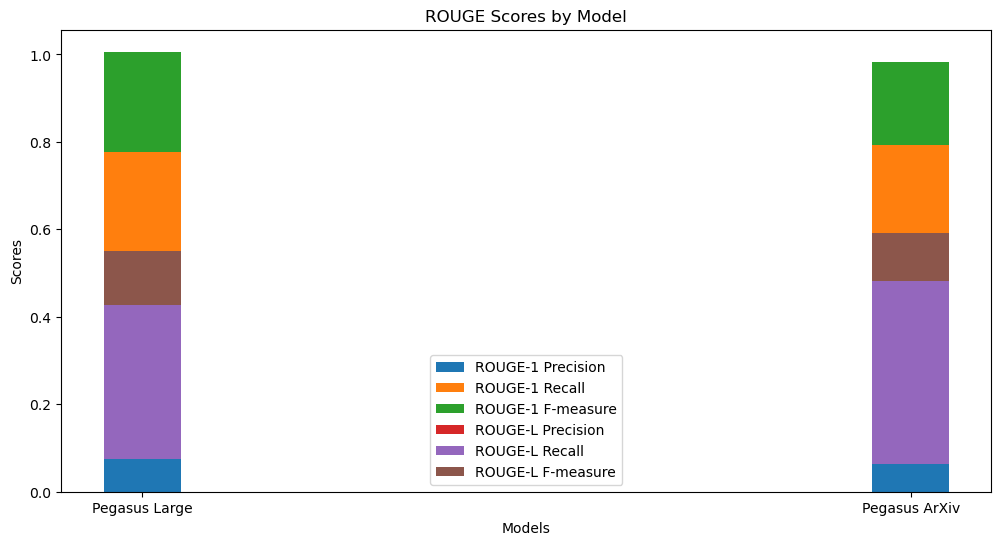

In [15]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['Pegasus Large', 'Pegasus ArXiv']
rouge_1_precision = [base_mean_rouge1[0], finetuned_mean_rouge1[0]]
rouge_1_recall = [base_mean_rouge1[1], finetuned_mean_rouge1[1]]
rouge_1_fmeasure = [base_mean_rouge1[2], finetuned_mean_rouge1[2]]
rouge_L_precision = [base_mean_rougeL[0], finetuned_mean_rougeL[0]]
rouge_L_recall = [base_mean_rougeL[1], finetuned_mean_rougeL[1]]
rouge_L_fmeasure = [base_mean_rougeL[2], finetuned_mean_rougeL[2]]

x = range(len(models))  # the label locations

# Creating the bar plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x, rouge_1_precision, width=0.1, label='ROUGE-1 Precision')
ax.bar(x, rouge_1_recall, width=0.1, bottom=rouge_1_precision, label='ROUGE-1 Recall')
ax.bar(x, rouge_1_fmeasure, width=0.1, bottom=rouge_1_recall, label='ROUGE-1 F-measure')
ax.bar(x, rouge_L_precision, width=0.1, bottom=rouge_1_fmeasure, label='ROUGE-L Precision')
ax.bar(x, rouge_L_recall, width=0.1, bottom=rouge_L_precision, label='ROUGE-L Recall')
ax.bar(x, rouge_L_fmeasure, width=0.1, bottom=rouge_L_recall, label='ROUGE-L F-measure')

# Adding labels
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('ROUGE Scores by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show the plot
plt.show()

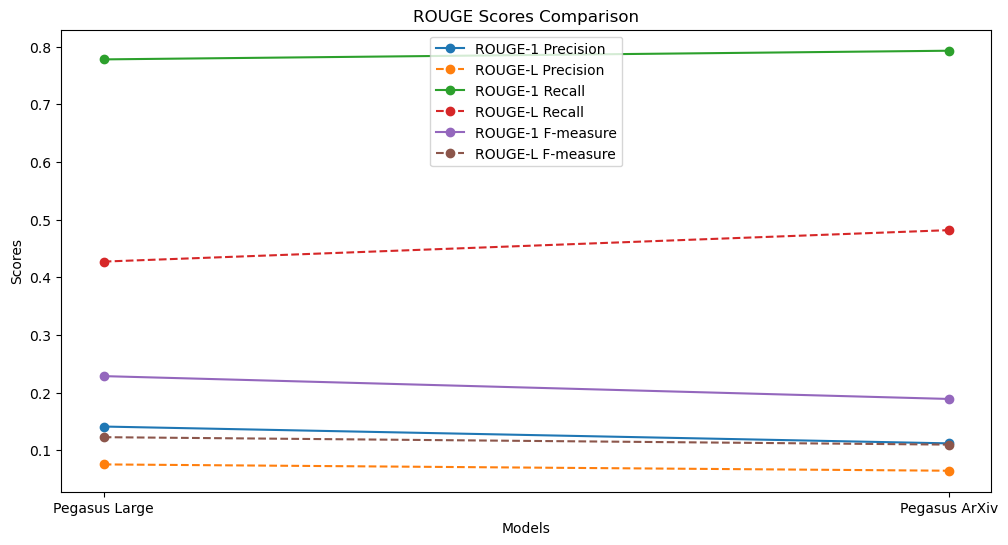

In [16]:
import matplotlib.pyplot as plt

# Data Preparation
models = ['Pegasus Large', 'Pegasus ArXiv']
metrics = ['Precision', 'Recall', 'F-measure']
rouge1_scores = [base_mean_rouge1, finetuned_mean_rouge1]
rougeL_scores = [base_mean_rougeL, finetuned_mean_rougeL]

# X-axis points
x = range(len(models))

# Plotting the Line Graph
plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):
    plt.plot(models, [score[i] for score in rouge1_scores], marker='o', label=f'ROUGE-1 {metric}')
    plt.plot(models, [score[i] for score in rougeL_scores], marker='o', linestyle='--', label=f'ROUGE-L {metric}')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('ROUGE Scores Comparison')
plt.legend()

plt.show()

## Saving Tokenizer and Model Weights to local PC

In [18]:
tokenizer.save_pretrained('Summarizer_tokenizer/')
model_base.save_pretrained('My_Pegasus_Large_Model/')
model_finetuned.save_pretrained('My_Pegasus_ArXiv_Model/')

## Creating a custom pipeline class for summarization for future use cases and Reusibility.

In [20]:
import pickle
import nltk
import pandas as pd
import torch
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
from concurrent.futures import ThreadPoolExecutor


# Downloading NLTK data
nltk.download('punkt')

class SummarizationPipeline:
    def __init__(self, model_name, tokenizer_name):
        self.tokenizer = PegasusTokenizer.from_pretrained(tokenizer_name)
        self.model = PegasusForConditionalGeneration.from_pretrained(model_name)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

    def summarize(self, texts):
        
        
        def _chunk_text(self, text, max_tokens):
            sentences = nltk.tokenize.sent_tokenize(text)
            current_chunk = []
            chunks = []
            current_len = 0

            for sentence in sentences:
                sentence_len = len(self.tokenizer.encode(sentence))
                if current_len + sentence_len > max_tokens:
                    chunks.append(" ".join(current_chunk))
                    current_chunk = []
                    current_len = 0
                current_chunk.append(sentence)
                current_len += sentence_len

            if current_chunk:
                chunks.append(" ".join(current_chunk))

            return chunks

        
        
    def _prepare_batches(self, texts, max_tokens, batch_size):
        for text in texts:
            chunks = self._chunk_text(text, max_tokens)
            for i in range(0, len(chunks), batch_size):
                yield chunks[i:i + batch_size]

                
                
    def _summarize_batch(self, batch):
        batch_tokens = self.tokenizer(batch, truncation=True, padding=True, return_tensors="pt").to(self.device)
        summary_ids = self.model.generate(**batch_tokens, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
        return [self.tokenizer.decode(ids, skip_special_tokens=True) for ids in summary_ids]

    
    
    def generate_summary(self, texts, max_tokens=512, batch_size=1):
        all_summaries = []
        with ThreadPoolExecutor() as executor:
            for batch in self._prepare_batches(texts, max_tokens, batch_size):
                futures = [executor.submit(self._summarize_batch, b) for b in batch]
                results = [f.result() for f in futures]
                document_summary = " ".join(results)
                all_summaries.append(document_summary)
        return all_summaries
        
        
        
        
        


'feature selection is an important aspect in the implementation of machine learning methods .the appropriate selection of informative features can reduce generalisation error as well as the storage and processing requirements for large datasets .in addition , parsimonious models can provide valuable insight into the relations underlying elements of the process under examination .there is a wealth of literature on the subject of feature selection when the relationship between variables is linear .unfortunately when the relation is non - linear feature selection becomes substantially more nuanced .kernel methods excel in modelling non - linear relations .unsurprisingly , a number of kernel - based feature selection algorithms have been proposed .early propositions , such as recursive feature elimination(rfe ) [ 1 ] can be computationally prohibitive , while attempts to learn a convex combination of low - rank kernels may fail to encapsulate nonlinearities in the underlying relation .rece